In [ ]:
! kaggle datasets download  jtiptj/chest-xray-pneumoniacovid19tuberculosis

Dataset URL: https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis
License(s): other
100% 1.73G/1.74G [00:59<00:00, 32.5MB/s]
100% 1.74G/1.74G [01:00<00:00, 31.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumoniacovid19tuberculosis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import (Flatten, Dense,GlobalAveragePooling2D,Dropout, BatchNormalization, Input, Add, Concatenate, PReLU, LayerNormalization, Conv2D, MaxPooling2D)
from tensorflow.keras.optimizers import Adam,AdamW,Lion

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121,EfficientNetB4, VGG16, ResNet152
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
# Other libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import cv2

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# Image properties and directories
IMG_SHAPE = (200, 200)
TRAIN_DIR = '/content/train'
VAL_DIR = '/content/val'
TEST_DIR = '/content/test'
BATCH_SIZE = 16

In [ ]:
train_val_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_val_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_data = train_val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5061 images belonging to 4 classes.
Found 6 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [ ]:
class_labels = list(train_data.class_indices.keys())
print(f"Detected Classes: {class_labels}")

Detected Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


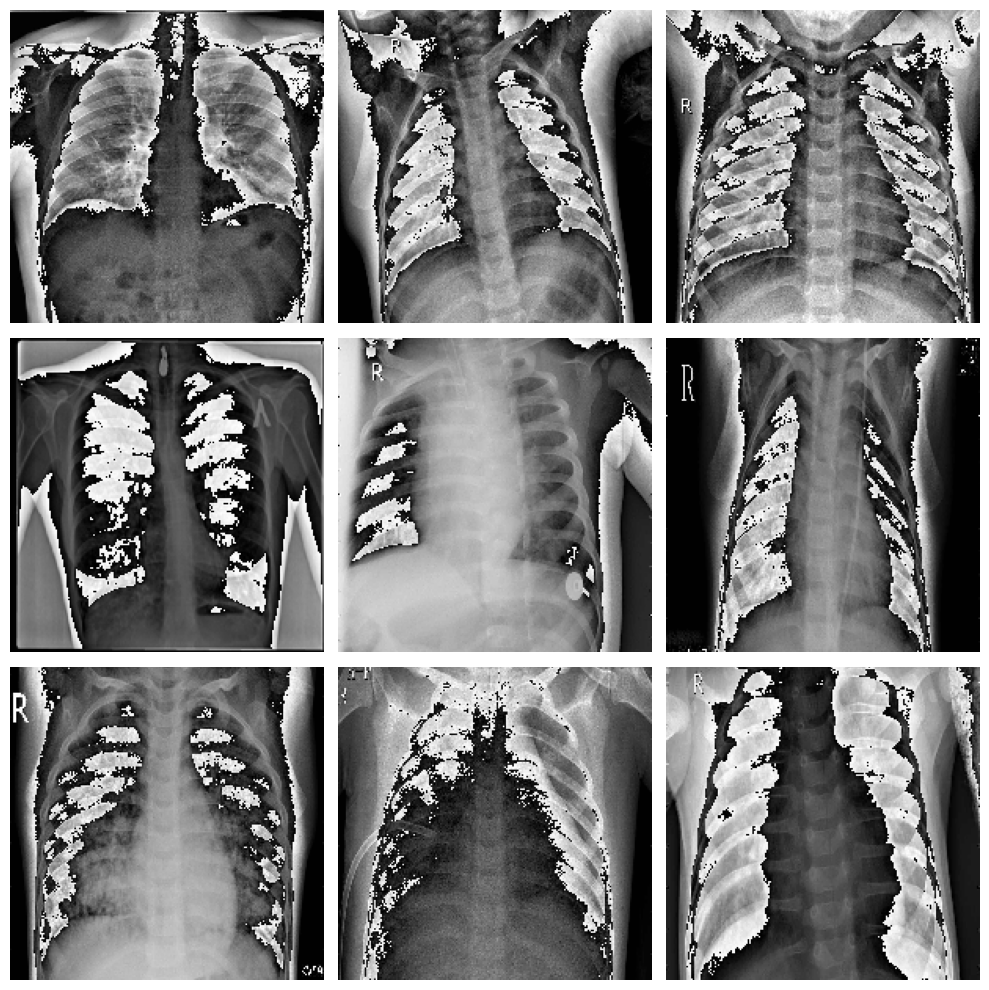

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample_img = next(train_data)[0][0] * 255
    plt.imshow(sample_img.astype('uint8'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    ModelCheckpoint(filepath='best_model_densenet.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8631 - loss: 0.3922
Epoch 1: val_loss improved from inf to 0.99699, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 116s 273ms/step - accuracy: 0.8633 - loss: 0.3917 - val_accuracy: 0.6667 - val_loss: 0.9970
Epoch 2/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.8750 - loss: 0.3354
Epoch 2: val_loss improved from 0.99699 to 0.73479, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3354 - val_accuracy: 0.6667 - val_loss: 0.7348
Epoch 3/10
315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9521 - loss: 0.1302
Epoch 3: val_loss improved from 0.73479 to 0.42707, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 67s 209ms/step - accuracy: 0.9522 - loss: 0.1301 - val_accuracy: 0.8333 - val_loss: 0.4271
Epoch 4/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 0.0421
Epoch 4: val

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.0630
Validation Loss: 0.06295491755008698, Validation Accuracy: 1.0
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 341ms/step - accuracy: 0.8628 - loss: 0.4328
Test Loss: 0.34302887320518494, Test Accuracy: 0.8897535800933838


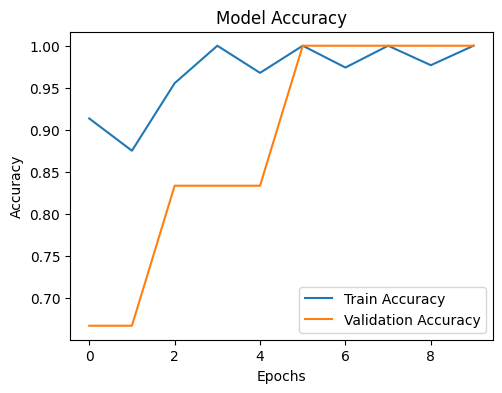

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

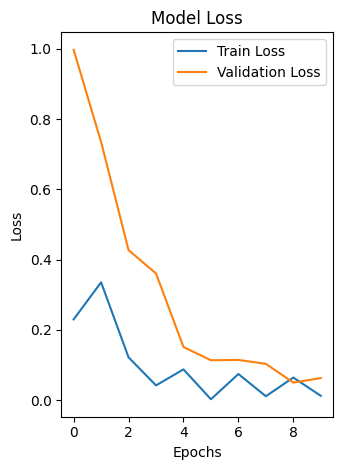

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred,axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 342ms/step


In [ ]:
print("Classification Report:")
print(classification_report(test_data.classes, y_pred_classes, target_names=class_labels))

Classification Report:
               precision    recall  f1-score   support

      COVID19       0.98      0.91      0.94       106
       NORMAL       0.90      0.76      0.83       234
    PNEUMONIA       0.87      0.95      0.91       390
TURBERCULOSIS       0.82      0.98      0.89        41

     accuracy                           0.89       771
    macro avg       0.89      0.90      0.89       771
 weighted avg       0.89      0.89      0.89       771



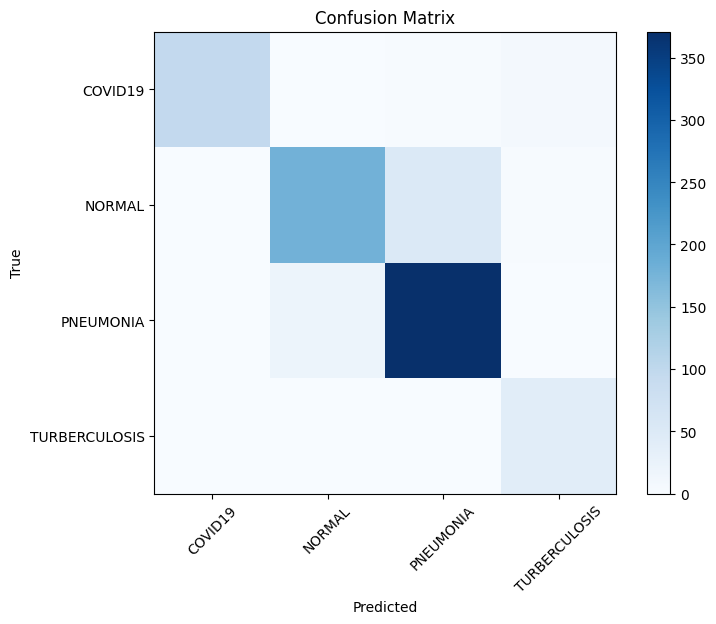

In [ ]:
conf_matrix = confusion_matrix(test_data.classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model.save("lungs_classification_model_densenet.h5")
print("Model saved to disk.")


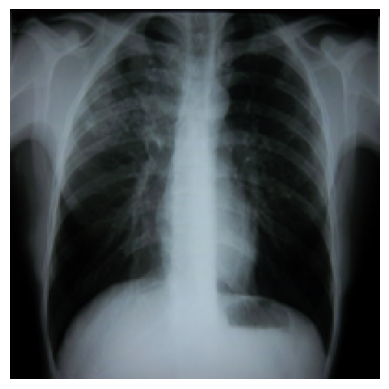

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: TURBERCULOSIS


In [ ]:

# Prediction function
def predict_image(model_path, image_path, class_labels):
    # Load the pre-trained model
    model = load_model("lungs_classification_model_densenet.h5")

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Display the image
    plt.imshow(np.array(img).astype('uint8'))
    plt.axis('off')
    plt.show()

    # Predict the class
    prediction = model.predict(img_array.reshape(1, 200, 200, 3))
    class_index = np.argmax(prediction)
    print(f"Predicted Class: {class_labels[class_index]}")

# Test the prediction function
predict_image("lungs_classification_model_densenet.h5", "/content/test/TURBERCULOSIS/Tuberculosis-690.png", class_labels)